<a href="https://colab.research.google.com/github/isacmoura/speed-prediction/blob/main/TCC2_Isac_Moura_(hm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importar bibliotecas necessárias

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn import metrics
from time import time
import pickle
import joblib
import datetime

# GLOBALS
seed = 42
path = "/content/drive/My Drive/Colab Notebooks/TCC/models"
datasets = "/content/drive/My Drive/Colab Notebooks/TCC/datasets"
csv_folder = "/content/drive/My Drive/Colab Notebooks/TCC/csv_files"

%matplotlib inline

In [3]:
!wget https://zenodo.org/record/3469741/files/2014_01-Traffic_Sensors_Fortaleza.csv
!ls

--2020-10-07 17:57:08--  https://zenodo.org/record/3469741/files/2014_01-Traffic_Sensors_Fortaleza.csv
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233042344 (222M) [text/plain]
Saving to: ‘2014_01-Traffic_Sensors_Fortaleza.csv’

2014_01-Traffic_Sen 100%[===================>] 222.25M  6.58MB/s    in 26s     

2020-10-07 17:57:36 (8.64 MB/s) - ‘2014_01-Traffic_Sensors_Fortaleza.csv’ saved [233042344/233042344]

2014_01-Traffic_Sensors_Fortaleza.csv  drive  sample_data


In [4]:
df = pd.read_csv('2014_01-Traffic_Sensors_Fortaleza.csv', warn_bad_lines=False, error_bad_lines=False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,1,284,3,16,25.0,56.0,49.812500,7.460050,125.0,12.0,60.0,49.224000,7.405797,16.0,38.0,71.0,50.250000,7.267221,5.0,37.0,62.0,50.000000,8.414274,1,67,49.842106,2014-01-14 23:40:00
1,1385001,1,285,3,23,24.0,60.0,48.913044,7.143943,125.0,12.0,60.0,48.992000,7.716472,20.0,35.0,57.0,49.849998,4.661277,30.0,27.0,52.0,44.766666,4.957710,1,67,53.133335,2014-01-14 23:45:00
2,1385001,1,286,3,20,27.0,59.0,49.500000,6.515367,136.0,12.0,60.0,48.926471,7.671215,22.0,41.0,63.0,50.818180,5.348206,17.0,30.0,61.0,43.352940,9.093897,1,67,49.761906,2014-01-14 23:50:00
3,1385001,2,0,2,10,29.0,56.0,48.700000,7.443790,131.0,12.0,60.0,48.587786,7.829159,2.0,48.0,51.0,49.500000,1.500000,28.0,27.0,56.0,44.821430,6.442346,1,67,46.500000,2014-01-15 00:00:00
4,1385001,2,1,3,21,41.0,58.0,50.285713,4.802210,119.0,24.0,60.0,49.445378,6.354642,11.0,40.0,58.0,48.181820,5.589246,51.0,30.0,60.0,45.960785,6.600537,1,67,45.714287,2014-01-15 00:05:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981203 entries, 0 to 981202
Data columns (total 28 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    981203 non-null  object 
 1   day_of_week  981203 non-null  int64  
 2   slot_of_day  981203 non-null  int64  
 3   lane         981203 non-null  int64  
 4   size5        981203 non-null  int64  
 5   min5         981203 non-null  float64
 6   max5         981203 non-null  float64
 7   avg5         981203 non-null  float64
 8   std5         981203 non-null  float64
 9   size30       981203 non-null  float64
 10  min30        981203 non-null  float64
 11  max30        981203 non-null  float64
 12  avg30        981203 non-null  float64
 13  std30        981203 non-null  float64
 14  size1w       981203 non-null  float64
 15  min1w        981203 non-null  float64
 16  max1w        981203 non-null  float64
 17  avg1w        981203 non-null  float64
 18  std1w        981203 non-

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
day_of_week,981203.0,2.994310,1.823518,0.000000,2.000000,3.000000,4.000000,6.000000
slot_of_day,981203.0,146.776017,81.701877,0.000000,78.000000,148.000000,217.000000,287.000000
lane,981203.0,2.462482,0.751932,1.000000,2.000000,2.000000,3.000000,5.000000
size5,981203.0,60.278322,45.258862,1.000000,21.000000,55.000000,89.000000,875.000000
min5,981203.0,17.540386,11.067515,1.000000,10.000000,14.000000,23.000000,79.000000
max5,981203.0,53.600810,10.333148,2.000000,49.000000,55.000000,60.000000,79.000000
avg5,981203.0,36.873116,10.203481,2.000000,28.196080,38.328000,45.894080,79.000000
std5,981203.0,8.570810,3.249439,0.000000,6.299801,8.347670,10.739144,32.500000
size30,981203.0,361.015220,264.188217,1.000000,129.000000,336.000000,533.000000,4509.000000
min30,981203.0,11.602114,7.804677,1.000000,6.000000,10.000000,13.000000,61.000000


# Pré-processamento

In [ ]:
df.drop(df.iloc[:, 14:24], inplace=True, axis=1) #removing from size1w to std2w

del df['sensor_id']
del df['timestamp5']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981203 entries, 0 to 981202
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   day_of_week  981203 non-null  int64  
 1   slot_of_day  981203 non-null  int64  
 2   lane         981203 non-null  int64  
 3   size5        981203 non-null  int64  
 4   min5         981203 non-null  float64
 5   max5         981203 non-null  float64
 6   avg5         981203 non-null  float64
 7   std5         981203 non-null  float64
 8   size30       981203 non-null  float64
 9   min30        981203 non-null  float64
 10  max30        981203 non-null  float64
 11  avg30        981203 non-null  float64
 12  std30        981203 non-null  float64
 13  working_day  981203 non-null  int64  
 14  speed_limit  981203 non-null  int64  
 15  label        981203 non-null  float64
dtypes: float64(10), int64(6)
memory usage: 119.8 MB


In [ ]:
df.isna().sum()

day_of_week    0
slot_of_day    0
lane           0
size5          0
min5           0
max5           0
avg5           0
std5           0
size30         0
min30          0
max30          0
avg30          0
std30          0
working_day    0
speed_limit    0
label          0
dtype: int64

# Separação em treino, teste e validação

In [ ]:
column_names = [*df]
column_names

['day_of_week',
 'slot_of_day',
 'lane',
 'size5',
 'min5',
 'max5',
 'avg5',
 'std5',
 'size30',
 'min30',
 'max30',
 'avg30',
 'std30',
 'working_day',
 'speed_limit',
 'label']

In [ ]:
X = df.iloc[:,:-1].values
y = df["label"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state = seed, shuffle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(627969, 15) (627969,)
(196241, 15) (196241,)
(156993, 15) (156993,)


# Treino e teste (sem cross validation)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

In [ ]:
rmse_metric = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse_metric)

3.7752265861612697


# Implementando treino e teste com cross validation

Observaremos os resultados utilizando K-Folds Cross Validation

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
data = df.iloc[:,:-1]
y = df["label"]
scores = []

for i in range(10):
    result = next(kf.split(data), None)
    X_train = data.iloc[result[0]]
    X_test = data.iloc[result[1]]
    y_train = y.iloc[result[0]]
    y_test = y.iloc[result[1]]
    
model = lr.fit(X_train, y_train)
pred = lr.predict(X_test)
scores.append(np.sqrt(metrics.mean_squared_error(y_test, pred)))

print("Scores from iteration: ", scores)
print("Mean from K-fold: ", np.mean(scores))

Scores from iteration:  [3.781305487943111]
Mean from K-fold:  3.781305487943111


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
mses = []
for idx_train, idx_test in kfold.split(X, y):
    X_train, y_train = X[idx_train], y[idx_train]
    X_test, y_test = X[idx_test], y[idx_test]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mses.append(metrics.mean_squared_error(y_test, y_pred))
    
mse = np.mean(mses)
rmse = np.sqrt(mse)

In [ ]:
print(mse)
print(rmse)

14.338197201216364
3.786581202247796


# Treinando com diferentes algoritmos

Utilizando:
- Linear Regression
- Random Forest
- Gradient Boosting
- Xgboost (com gpu)

In [ ]:
models = {}
models["LR"] = {'model': LinearRegression()}
models["RFR"] = {'model': RandomForestRegressor()}
models["GB"] = {'model': GradientBoostingRegressor()}
models["XGB"] = {'model': XGBRegressor(tree_method='gpu_hist')}

In [ ]:
for item in models:
    start = time.time()
    print(f"Treinando {item}")
    models[item]['model'].fit(X_train, y_train)
    models[item]['y_pred'] = models[item]['model'].predict(X_test)
    models[item]['rmse'] = np.sqrt(metrics.mean_squared_error(y_test, models[item]['y_pred']))
    models[item]['execution'] = time.time() - start

Treinando LR
Treinando RFR
Treinando GB
Treinando XGB


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:34:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
train = pd.DataFrame(models)

In [ ]:
train.T[['y_pred', 'rmse', 'execution']]

,y_pred,rmse,execution
LR,"[48.349358418838605, 48.492168364459786, 48.78...",3.80425,0.967633
RFR,"[48.42009136199951, 49.10262470245361, 50.0304...",3.71906,2547.36
GB,"[48.509154451655085, 48.716102438985246, 49.15...",3.76883,520.354
XGB,"[48.70565, 48.564407, 48.976498, 48.941372, 49...",3.76575,3.72172


# Treinando com XGBoost

In [ ]:
xgr = xgb.XGBRegressor(tree_method='gpu_hist', objective ='reg:squarederror') # gpu enabled

In [ ]:
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred = xgr.predict(X_test)

In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
rmse

3.7386514349957443

# Importância das features

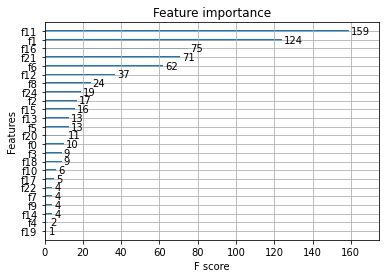

In [ ]:
# Testando
xgb.plot_importance(xgr)

['day_of_week', 'slot_of_day', 'lane', 'size5', 'min5', 'max5', 'avg5', 'std5', 'size30', 'min30', 'max30', 'avg30', 'std30', 'size1w', 'min1w', 'max1w', 'avg1w', 'std1w', 'size2w', 'min2w', 'max2w', 'avg2w', 'std2w', 'working_day', 'speed_limit', 'label']


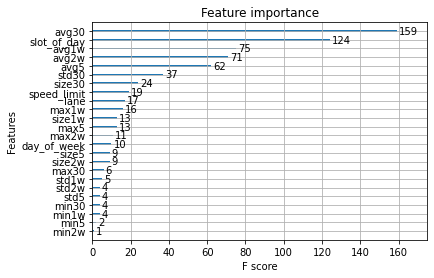

In [ ]:
xgr.get_booster().feature_names = column_names
print(xgr.get_booster().feature_names)
xgb.plot_importance(xgr)

# Usando early stopping e eval_set

In [ ]:
eval_set = [(X_val, y_val)]

Definindo parâmetros para uso no Random Search

In [ ]:
params = {
        'learning_rate': [0.1, 0.01],
        'max_depth': [3, 5, 7, 9, 12],
}

In [ ]:
# Instaciando novo modelo
model = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror')

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [ ]:
# randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(model, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, random_state=seed, verbose=2)

1- Utilizar treino + validação para fazer Randomized Search.  
2- Com os hyperparameters, fazer treino com os melhores.  
3- Avaliar o algoritmo utilizando o conjunto de teste.  
4- Tabular todos os resultados em uma planilha a título de comparação (algoritmos e seus hiperparâmetros).

Unindo dados de treino e validação/teste e validação para treinamento no Randomized Search

In [ ]:
data = np.concatenate((X_train, X_val), axis=0)
target = np.concatenate((y_train, y_val))

In [ ]:
start = time()
random_search.fit(X=data, y=target)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, 7)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] ................... max_depth=3, learning_rate=0.1, total=  24.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s


[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] ................... max_depth=3, learning_rate=0.1, total=  24.7s
[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] ................... max_depth=3, learning_rate=0.1, total=  24.7s
[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] ................... max_depth=3, learning_rate=0.1, total=  24.8s
[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] ................... max_depth=3, learning_rate=0.1, total=  24.8s
[CV] max_depth=5, learning_rate=0.1 ..................................
[CV] ................... max_depth=5, learning_rate=0.1, total=  29.9s
[CV] max_depth=5, learning_rate=0.1 ..................................
[CV] ................... max_depth=5, learning_rate=0.1, total=  30.2s
[CV] max_depth=5, learning_rate=0.1 ..................................
[CV] ................... max_depth=5, learning_rate=0.1, total=  29.9s
[CV] m

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 89.9min finished


RandomizedSearchCV took 5723.82 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.864 (std: 0.001)
Parameters: {'max_depth': 12, 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: 0.864 (std: 0.000)
Parameters: {'max_depth': 9, 'learning_rate': 0.01}

Model with rank: 3
Mean validation score: 0.863 (std: 0.000)
Parameters: {'max_depth': 7, 'learning_rate': 0.01}

Model with rank: 4
Mean validation score: 0.861 (std: 0.000)
Parameters: {'max_depth': 5, 'learning_rate': 0.01}

Model with rank: 5
Mean validation score: 0.861 (std: 0.000)
Parameters: {'max_depth': 5, 'learning_rate': 0.1}

Model with rank: 6
Mean validation score: 0.860 (std: 0.000)
Parameters: {'max_depth': 3, 'learning_rate': 0.1}

Model with rank: 7
Mean validation score: 0.860 (std: 0.000)
Parameters: {'max_depth': 7, 'learning_rate': 0.1}



In [ ]:
random_search.best_params_

{'learning_rate': 0.01, 'max_depth': 12}

In [ ]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

# Bateria de treinamentos com XGBoost

In [ ]:
model_1 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

model_1.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred = model_1.predict(X_test, ntree_limit=model_1.best_ntree_limit)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

print(f"RMSE: {rmse}")
print(f"Best Score: {model_1.best_score}\nBest ntree: {model_1.best_ntree_limit}")

RMSE: 3.746037923953082
Best Score: 3.748977
Best ntree: 855


In [ ]:
model_2 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=9, random_state=seed)

model_2.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_2 = model_2.predict(X_test, ntree_limit=model_2.best_ntree_limit)

rmse_2 = np.sqrt(metrics.mean_squared_error(y_test, pred_2))
print(f"RMSE: {rmse_2}")
print(f"Best Score: {model_2.best_score}\nBest ntree: {model_2.best_ntree_limit}")

RMSE: 3.761557234578361
Best Score: 3.766927
Best ntree: 785


In [ ]:
model_3 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=7, random_state=seed)

model_3.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_3 = model_3.predict(X_test, ntree_limit=model_3.best_ntree_limit)

rmse_3 = np.sqrt(metrics.mean_squared_error(y_test, pred_3))
print(f"RMSE: {rmse_3}")
print(f"Best Score: {model_3.best_score}\nBest ntree: {model_3.best_ntree_limit}")

RMSE: 3.778523101712348
Best Score: 3.781463
Best ntree: 1706


In [ ]:
# Instaciando novo modelo
model_4 = xgb.XGBRegressor(tree_method='gpu_hist', objective ='reg:squarederror',
                           max_depth=5, learning_rate=0.01, n_estimators=5000)

model_4.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_4 = model_4.predict(X_test, ntree_limit=model_4.best_ntree_limit)

rmse_4 = np.sqrt(metrics.mean_squared_error(y_test, pred_4))
print(f"RMSE: {rmse_4}")
print(f"Best Score: {model_4.best_score}\nBest ntree: {model_4.best_ntree_limit}")

RMSE: 3.794371903380169
Best Score: 3.796256
Best ntree: 4161


In [ ]:
model_5 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.1,
                            max_depth=5, random_state=seed)

model_5.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_5 = model_5.predict(X_test, ntree_limit=model_5.best_ntree_limit)

rmse_5 = np.sqrt(metrics.mean_squared_error(y_test, pred_5))
print(f"RMSE: {rmse_5}")
print(f"Best Score: {model_5.best_score}\nBest ntree: {model_5.best_ntree_limit}")

RMSE: 3.792886068435074
Best Score: 3.792131
Best ntree: 696


In [ ]:
model_6 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.1,
                            max_depth=3, random_state=seed)

model_6.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_6 = model_6.predict(X_test, ntree_limit=model_6.best_ntree_limit)

rmse_6 = np.sqrt(metrics.mean_squared_error(y_test, pred_6))
print(f"RMSE: {rmse_6}")
print(f"Best Score: {model_6.best_score}\nBest ntree: {model_6.best_ntree_limit}")

RMSE: 3.813442792112462
Best Score: 3.818644
Best ntree: 1322


In [ ]:
model_7 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.1,
                            max_depth=7, random_state=seed)

model_7.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_7 = model_7.predict(X_test, ntree_limit=model_7.best_ntree_limit)

rmse_7 = np.sqrt(metrics.mean_squared_error(y_test, pred_7))
print(f"RMSE: {rmse_7}")
print(f"Best Score: {model_7.best_score}\nBest ntree: {model_7.best_ntree_limit}")

RMSE: 3.7812545355186513
Best Score: 3.781269
Best ntree: 279


In [ ]:
model_8 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

model_8.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=30, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_8 = model_8.predict(X_test, ntree_limit=model_8.best_ntree_limit)

rmse_8 = np.sqrt(metrics.mean_squared_error(y_test, pred_8))
print(f"RMSE: {rmse_8}")
print(f"Best Score: {model_8.best_score}\nBest ntree: {model_8.best_ntree_limit}")

RMSE: 3.746037923953082
Best Score: 3.748977
Best ntree: 855


In [ ]:
model_9 = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=15, random_state=seed)

model_9.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_9 = model_9.predict(X_test, ntree_limit=model_9.best_ntree_limit)

rmse_9 = np.sqrt(metrics.mean_squared_error(y_test, pred_9))
print(f"RMSE: {rmse_9}")
print(f"Best Score: {model_9.best_score}\nBest ntree: {model_9.best_ntree_limit}")

RMSE: 3.7547198899401932
Best Score: 3.754291
Best ntree: 819


# Salvando modelos

In [ ]:
# Evitando retrabalho, já que todas as variáveis começam por 'model_"

for i in range(1,10):
  joblib.dump(vars()[f'model_{i}'], f'{path}/model_{i}.pkl')

# Feature importance do melhor modelo

O modelo de melhor desempenho foi o modelo armazenado na variável `model_1`, com RMSE de 3,74603.  
Vamos desenhar a importância das features deste modelo.

In [ ]:
model_1 = joblib.load(f'{path}/model_1.pkl')

In [ ]:
model_1.feature_importances_

array([0.0019743 , 0.00427621, 0.00454823, 0.00363982, 0.00330007,
       0.00370572, 0.0054574 , 0.00374809, 0.00471139, 0.00390885,
       0.00405207, 0.9370167 , 0.00459172, 0.00394977, 0.01111963],
      dtype=float32)

In [ ]:
model_1.get_booster().feature_names = column_names

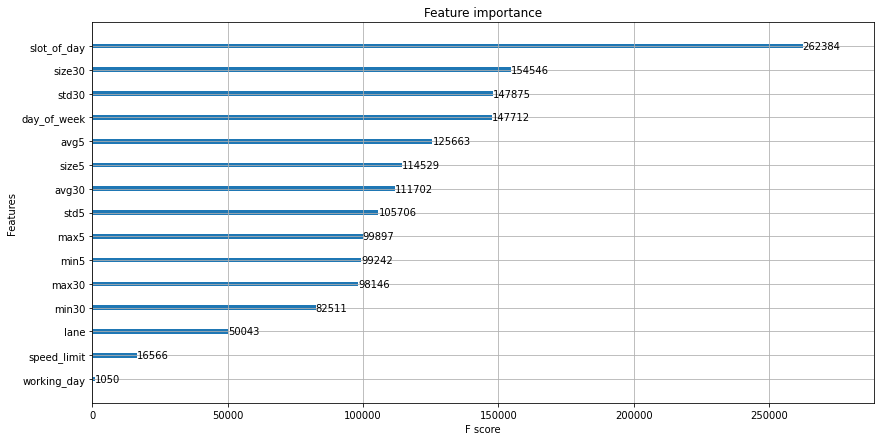

In [ ]:
xgb.plot_importance(model_1.get_booster())

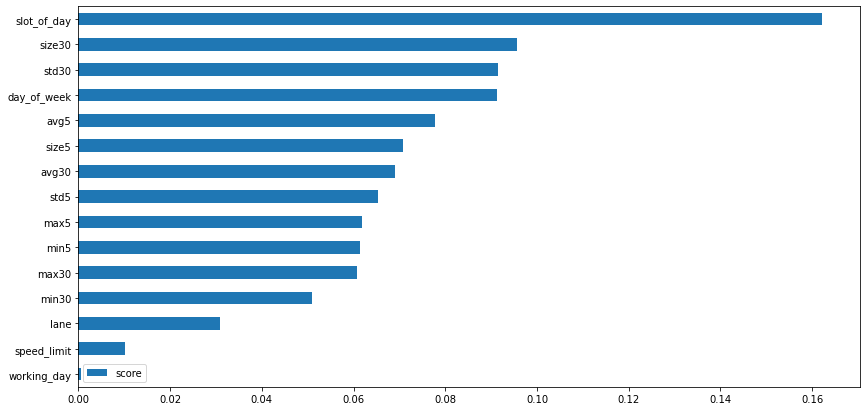

In [ ]:
# Get the booster from the xgbmodel
booster = model_1.get_booster()

importance = booster.get_score(importance_type="weight")

total = sum(importance.values())

# iter into keys
for key in importance.keys():
    importance[key] = importance[key]/total

keys = list(importance.keys())
values = list(importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')

# Treinando modelos separadamente para features de 5 minutos

In [ ]:
# Instanciando melhor modelo

best_xgb = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

Retirando features de 30 minutos do dataset

In [ ]:
df.head()

,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label
0,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,50.799999
1,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,52.692307
2,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,50.000000
3,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,48.615383
4,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,48.000000


## Remoção das features

In [ ]:
# As colunas que queremos remover estão entre as posições 8 e 12.
df.columns[8:13]

Index(['size30', 'min30', 'max30', 'avg30', 'std30'], dtype='object')

In [ ]:
df_5min = df.copy()

df_5min.drop(df_5min.iloc[:, 8:13], inplace=True, axis=1) #removing from size30 to std30

In [ ]:
df_5min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2950522 entries, 0 to 1302562
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   day_of_week  int64  
 1   slot_of_day  int64  
 2   lane         int64  
 3   size5        int64  
 4   min5         float64
 5   max5         float64
 6   avg5         float64
 7   std5         float64
 8   size1w       float64
 9   min1w        float64
 10  max1w        float64
 11  avg1w        float64
 12  std1w        float64
 13  size2w       float64
 14  min2w        float64
 15  max2w        float64
 16  avg2w        float64
 17  std2w        float64
 18  working_day  int64  
 19  speed_limit  int64  
dtypes: float64(14), int64(6)
memory usage: 472.7 MB


In [ ]:
column_names_5min = [*df_5min]

## Divisão em treino, teste e validação

In [ ]:
X = df.iloc[:,:-1].values
y = df["label"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state = seed, shuffle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [ ]:
eval_set = [(X_val, y_val)]

## Treinamento

Utilizando XGBoost

In [ ]:
best_xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

Utilizando Linear Regression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Predições

In [ ]:
pred_xgb = best_xgb.predict(X_test, ntree_limit=best_xgb.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, pred_lr))

print(f'RMSE - Linear Regression: {rmse_lr}\nRMSE - XGBoost: {rmse_xgb}')

RMSE - Linear Regression: 3.954511845708405
RMSE - XGBoost: 3.746037923953082


# Treinando modelos separadamente para features de 30 minutos

Retirando features de 05 minutos do dataset

In [ ]:
df.head()

,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,working_day,speed_limit,label
0,1,284,3,16,25.0,56.0,49.812500,7.460050,125.0,12.0,60.0,49.224000,7.405797,1,67,49.842106
1,1,285,3,23,24.0,60.0,48.913044,7.143943,125.0,12.0,60.0,48.992000,7.716472,1,67,53.133335
2,1,286,3,20,27.0,59.0,49.500000,6.515367,136.0,12.0,60.0,48.926471,7.671215,1,67,49.761906
3,2,0,2,10,29.0,56.0,48.700000,7.443790,131.0,12.0,60.0,48.587786,7.829159,1,67,46.500000
4,2,1,3,21,41.0,58.0,50.285713,4.802210,119.0,24.0,60.0,49.445378,6.354642,1,67,45.714287


## Remoção das features

In [ ]:
# As colunas que queremos remover estão entre as posições 3 e 7.
df.columns[3:8]

Index(['size5', 'min5', 'max5', 'avg5', 'std5'], dtype='object')

In [ ]:
df_30min = df.copy()

df_30min.drop(df_30min.iloc[:, 3:8], inplace=True, axis=1) #removing from size5 to std5

In [ ]:
df_30min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981203 entries, 0 to 981202
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   day_of_week  981203 non-null  int64  
 1   slot_of_day  981203 non-null  int64  
 2   lane         981203 non-null  int64  
 3   size30       981203 non-null  float64
 4   min30        981203 non-null  float64
 5   max30        981203 non-null  float64
 6   avg30        981203 non-null  float64
 7   std30        981203 non-null  float64
 8   working_day  981203 non-null  int64  
 9   speed_limit  981203 non-null  int64  
 10  label        981203 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 82.3 MB


In [ ]:
column_names_30min = [*df_30min]

## Divisão em treino, teste e validação

In [ ]:
X = df.iloc[:,:-1].values
y = df["label"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state = seed, shuffle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [ ]:
eval_set = [(X_val, y_val)]

## Treinamento

Utilizando XGBoost

In [ ]:
best_xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

Utilizando Linear Regression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Predições

In [ ]:
pred_xgb = best_xgb.predict(X_test, ntree_limit=best_xgb.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, pred_lr))

print(f'RMSE - Linear Regression: {rmse_lr}\nRMSE - XGBoost: {rmse_xgb}')

RMSE - Linear Regression: 3.954511845708405
RMSE - XGBoost: 3.746037923953082


# Utilizando outros meses para treino

avg5 de 30 minutos a diante é igual ao label de 30 minutos atrás.

In [ ]:
agosto = pd.read_csv(f"{datasets}/2014_08-Traffic_Sensors_Fortaleza.csv")
setembro = pd.read_csv(f"{datasets}/2014_09-Traffic_Sensors_Fortaleza.csv")
test = pd.read_csv(f"{datasets}/2014_10-Traffic_Sensors_Fortaleza.csv")

data = pd.concat([agosto, setembro])
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,50.799999,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,50.000000,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,48.615383,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,48.000000,2014-08-01 00:20:00


In [ ]:
data[((data["timestamp5"] == "2014-08-01 00:30:00") & (data["sensor_id"] == 1385001))]

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
6,1385001,4,6,3,35,30.0,59.0,50.8,6.060646,200.0,30.0,62.0,50.685,5.617453,29.0,24.0,59.0,47.862068,6.218572,14.0,40.0,57.0,50.57143,4.100771,1,67,51.416668,2014-08-01 00:30:00


## Retirando features desnecessárias

In [ ]:
del data['sensor_id']
del data['timestamp5']

del test['sensor_id']
del test['timestamp5']

In [ ]:
data.head()

,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label
0,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,50.799999
1,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,52.692307
2,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,50.000000
3,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,48.615383
4,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,48.000000


## Split do dataset de treino e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

## Treinando
Realizando treinamento com Regressão Linear e XGBoost.

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

3.92862189551909


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

3.8013414627917927

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

855 3.798028


## Importância das features

In [ ]:
column_names = [*data]
column_names

['day_of_week',
 'slot_of_day',
 'lane',
 'size5',
 'min5',
 'max5',
 'avg5',
 'std5',
 'size30',
 'min30',
 'max30',
 'avg30',
 'std30',
 'size1w',
 'min1w',
 'max1w',
 'avg1w',
 'std1w',
 'size2w',
 'min2w',
 'max2w',
 'avg2w',
 'std2w',
 'working_day',
 'speed_limit',
 'label']

In [ ]:
xgboost.get_booster().feature_names = column_names

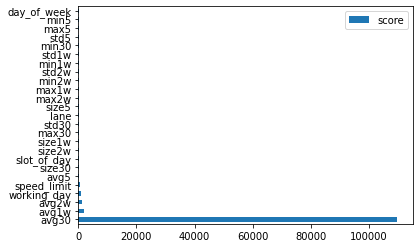

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

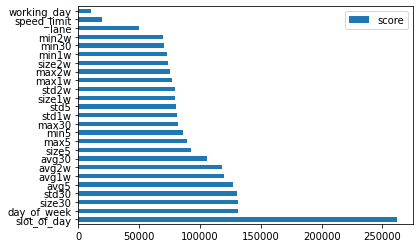

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

# Treinando somente com avg30
Conforme a importância das features mostrou, a feature `avg30` é bem mais importante que as outras. Portanto será realizado o treinamento e teste somente com esta feature.

In [ ]:
data.head()

In [ ]:
data["avg30"]

0          49.678571
1          50.114943
2          50.494681
3          50.437838
4          50.576531
             ...    
1302558    21.720000
1302559    20.541667
1302560    15.555556
1302561    12.937500
1302562    19.600000
Name: avg30, Length: 2950522, dtype: float64

In [ ]:
label = data["label"].values
tr_data = data["avg30"].values

X = test["avg30"].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

In [ ]:
X_val = X_val.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## Treinando
Realizando treinamento com Regressão Linear e XGBoost.

In [ ]:
tr_data = tr_data.reshape(-1, 1)

In [ ]:
tr_data

array([[49.67857143],
       [50.11494253],
       [50.49468085],
       ...,
       [15.55555556],
       [12.9375    ],
       [19.6       ]])

In [ ]:
tr_data.shape

(2950522, 1)

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

4.144602153463623


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.141584907225499

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

1001 4.147957


## Importância das features

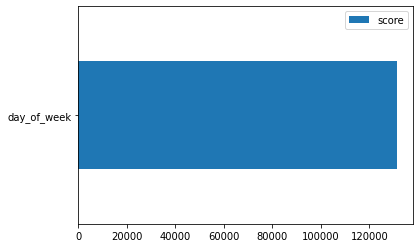

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

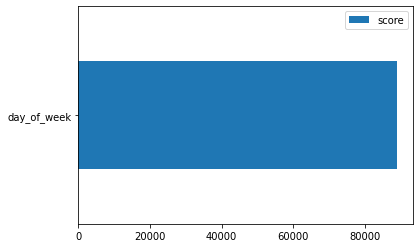

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

# Ajustando label para 02 horas adiante

In [ ]:
agosto = pd.read_csv(f"{datasets}/2014_08-Traffic_Sensors_Fortaleza.csv", parse_dates=["timestamp5"])
setembro = pd.read_csv(f"{datasets}/2014_09-Traffic_Sensors_Fortaleza.csv", parse_dates=["timestamp5"])
test = pd.read_csv(f"{datasets}/2014_10-Traffic_Sensors_Fortaleza.csv", parse_dates=["timestamp5"])

data = pd.concat([agosto, setembro], ignore_index=True)
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,50.799999,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,50.000000,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,48.615383,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,48.000000,2014-08-01 00:20:00


### Dados de treino

In [ ]:
data_copy = data.copy()

In [ ]:
data_copy.index[-1]

2950521

In [ ]:
# before transformation
data_copy.head(10)

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,...,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,...,4.521537,32.0,25.0,58.0,47.562500,7.676822,1,67,50.799999,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,...,5.250657,26.0,33.0,59.0,50.769230,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,...,5.186414,24.0,11.0,56.0,47.250000,9.138973,1,67,50.000000,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,...,5.188073,21.0,40.0,55.0,48.571430,4.593696,1,67,48.615383,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,...,5.469811,14.0,42.0,57.0,49.500000,4.238430,1,67,48.000000,2014-08-01 00:20:00
5,1385001,4,5,3,32,32.0,58.0,50.500000,5.442885,198.0,...,5.435704,19.0,32.0,58.0,46.684212,7.616137,1,67,47.909092,2014-08-01 00:25:00
6,1385001,4,6,3,35,30.0,59.0,50.800000,6.060646,200.0,...,6.218572,14.0,40.0,57.0,50.571430,4.100771,1,67,51.416668,2014-08-01 00:30:00
7,1385001,4,7,3,26,44.0,60.0,52.692307,3.516655,192.0,...,5.138901,22.0,36.0,60.0,50.454544,5.323424,1,67,48.368420,2014-08-01 00:35:00
8,1385001,4,8,3,32,38.0,60.0,50.000000,5.618051,192.0,...,6.514599,18.0,43.0,58.0,51.611111,4.584259,1,67,49.863636,2014-08-01 00:40:00
9,1385001,4,9,3,26,27.0,57.0,48.615383,7.452810,188.0,...,5.607089,11.0,42.0,56.0,49.636364,4.656818,1,67,48.666668,2014-08-01 00:45:00


In [ ]:
hours_added = datetime.timedelta(hours = 2)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = data_copy['sensor_id'].astype(str) + data_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(data_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 2 hours information
timePlus2h = data_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+2h
sensor_timePlus2h = (data_copy['sensor_id'].astype(str) + timePlus2h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus2h
new_label = sensor_timePlus2h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
data_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
data_copy.head(10)

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,...,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,...,4.521537,32.0,25.0,58.0,47.562500,7.676822,1,67,50.809525,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,...,5.250657,26.0,33.0,59.0,50.769230,4.979247,1,67,48.500000,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,...,5.186414,24.0,11.0,56.0,47.250000,9.138973,1,67,51.611110,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,...,5.188073,21.0,40.0,55.0,48.571430,4.593696,1,67,49.055557,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,...,5.469811,14.0,42.0,57.0,49.500000,4.238430,1,67,49.947370,2014-08-01 00:20:00
5,1385001,4,5,3,32,32.0,58.0,50.500000,5.442885,198.0,...,5.435704,19.0,32.0,58.0,46.684212,7.616137,1,67,47.400000,2014-08-01 00:25:00
6,1385001,4,6,3,35,30.0,59.0,50.800000,6.060646,200.0,...,6.218572,14.0,40.0,57.0,50.571430,4.100771,1,67,49.000000,2014-08-01 00:30:00
7,1385001,4,7,3,26,44.0,60.0,52.692307,3.516655,192.0,...,5.138901,22.0,36.0,60.0,50.454544,5.323424,1,67,49.700000,2014-08-01 00:35:00
8,1385001,4,8,3,32,38.0,60.0,50.000000,5.618051,192.0,...,6.514599,18.0,43.0,58.0,51.611111,4.584259,1,67,48.384617,2014-08-01 00:40:00
9,1385001,4,9,3,26,27.0,57.0,48.615383,7.452810,188.0,...,5.607089,11.0,42.0,56.0,49.636364,4.656818,1,67,49.875000,2014-08-01 00:45:00


In [ ]:
data_copy.tail()

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,...,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
2950517,AT911,1,279,1,4,4.0,19.0,11.0,5.43139,25.0,...,10.274023,2.0,9.0,14.0,11.500000,2.500000,1,60,20.000000,2014-09-30 23:15:00
2950518,AT911,1,280,1,2,3.0,6.0,4.5,1.50000,24.0,...,3.500000,3.0,8.0,67.0,37.666668,24.087803,1,60,21.799999,2014-09-30 23:20:00
2950519,AT911,1,282,2,1,37.0,37.0,37.0,0.00000,18.0,...,4.000000,2.0,5.0,9.0,7.000000,2.000000,1,60,20.500000,2014-09-30 23:30:00
2950520,AT911,1,283,1,1,13.0,13.0,13.0,0.00000,16.0,...,15.572412,3.0,4.0,41.0,24.333334,15.326085,1,60,14.333333,2014-09-30 23:35:00
2950521,AT911,1,286,1,5,4.0,75.0,21.8,26.70131,20.0,...,1.500000,1.0,42.0,42.0,42.000000,0.000000,1,60,18.666666,2014-09-30 23:50:00


In [ ]:
data_copy.isna().sum()

sensor_id      0
day_of_week    0
slot_of_day    0
lane           0
size5          0
min5           0
max5           0
avg5           0
std5           0
size30         0
min30          0
max30          0
avg30          0
std30          0
size1w         0
min1w          0
max1w          0
avg1w          0
std1w          0
size2w         0
min2w          0
max2w          0
avg2w          0
std2w          0
working_day    0
speed_limit    0
label          0
timestamp5     0
dtype: int64

In [ ]:
data_copy.to_csv('data-02hours.csv')
!cp data-02hours.csv '/datasets'

### Dados de teste

In [ ]:
test_copy = test.copy()

In [ ]:
test_copy.index

RangeIndex(start=0, stop=1715253, step=1)

In [ ]:
hours_added = datetime.timedelta(hours = 2)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = test_copy['sensor_id'].astype(str) + test_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(test_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 2 hours information
timePlus2h = test_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+2h
sensor_timePlus2h = (test_copy['sensor_id'].astype(str) + timePlus2h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus2h
new_label = sensor_timePlus2h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
test_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
test_copy.to_csv('test-02hours.csv')

## Treinando com dataset ajustado para 2 horas

### Removendo features desnecessárias

In [ ]:
## Only if kernel restarted

# Agosto + Setembro de 2014
data_ver = pd.read_csv(f'{datasets}/data-02hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test_ver = pd.read_csv(f'{datasets}/test-02hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
hours_added = datetime.timedelta(hours = 2)
index = 555555
hours_ahead = data.loc[index, "timestamp5"] + hours_added

print(data.loc[index, ["sensor_id", "label"]])
data[((data["timestamp5"] == hours_ahead) & (data["sensor_id"] == data["sensor_id"].loc[index]))][["sensor_id", "avg5"]]

sensor_id    1385133
label        40.9595
Name: 555555, dtype: object


,sensor_id,avg5
555579,1385133,39.241665


In [ ]:
del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

In [ ]:
data.head()

,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label
0,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,50.809525
1,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,48.500000
2,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,51.611110
3,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,49.055557
4,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,49.947370


### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

4.7824085617720895


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.25498473265828

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

1070 4.25802


### Importância das features

In [ ]:
column_names = [*data]
column_names

In [ ]:
xgboost.get_booster().feature_names = column_names

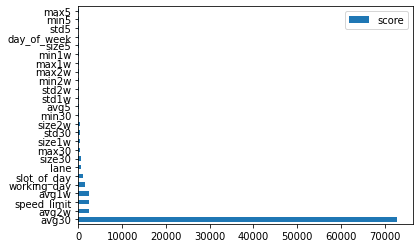

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

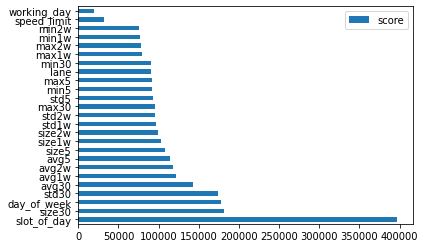

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

# Ajustando label para 03 horas adiante

In [ ]:
data_copy = data.copy()

In [ ]:
data_copy.index[-1]

2950521

In [ ]:
# before transformation
data_copy.head(10)

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,...,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,...,4.521537,32.0,25.0,58.0,47.562500,7.676822,1,67,50.799999,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,...,5.250657,26.0,33.0,59.0,50.769230,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,...,5.186414,24.0,11.0,56.0,47.250000,9.138973,1,67,50.000000,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,...,5.188073,21.0,40.0,55.0,48.571430,4.593696,1,67,48.615383,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,...,5.469811,14.0,42.0,57.0,49.500000,4.238430,1,67,48.000000,2014-08-01 00:20:00
5,1385001,4,5,3,32,32.0,58.0,50.500000,5.442885,198.0,...,5.435704,19.0,32.0,58.0,46.684212,7.616137,1,67,47.909092,2014-08-01 00:25:00
6,1385001,4,6,3,35,30.0,59.0,50.800000,6.060646,200.0,...,6.218572,14.0,40.0,57.0,50.571430,4.100771,1,67,51.416668,2014-08-01 00:30:00
7,1385001,4,7,3,26,44.0,60.0,52.692307,3.516655,192.0,...,5.138901,22.0,36.0,60.0,50.454544,5.323424,1,67,48.368420,2014-08-01 00:35:00
8,1385001,4,8,3,32,38.0,60.0,50.000000,5.618051,192.0,...,6.514599,18.0,43.0,58.0,51.611111,4.584259,1,67,49.863636,2014-08-01 00:40:00
9,1385001,4,9,3,26,27.0,57.0,48.615383,7.452810,188.0,...,5.607089,11.0,42.0,56.0,49.636364,4.656818,1,67,48.666668,2014-08-01 00:45:00


In [ ]:
hours_added = datetime.timedelta(hours = 3)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = data_copy['sensor_id'].astype(str) + data_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(data_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 3 hours information
timePlus3h = data_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+3h
sensor_timePlus3h = (data_copy['sensor_id'].astype(str) + timePlus3h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus3h
new_label = sensor_timePlus3h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
data_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
data_copy.to_csv('data-03hours.csv')

In [ ]:
test_copy = test.copy()

In [ ]:
test_copy.index

RangeIndex(start=0, stop=1715253, step=1)

In [ ]:
hours_added = datetime.timedelta(hours = 3)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = test_copy['sensor_id'].astype(str) + test_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(test_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 3 hours information
timePlus3h = test_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+3h
sensor_timePlus3h = (test_copy['sensor_id'].astype(str) + timePlus3h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus3h
new_label = sensor_timePlus3h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
test_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
test_copy.to_csv('test-03hours.csv')

## Treinando com dataset ajustado para 3 horas

### Removendo features desnecessárias

In [ ]:
## Only if kernel restarted

# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-03hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-03hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
hours_added = datetime.timedelta(hours = 3)
index = 1000001
hours_ahead = data.loc[index, "timestamp5"] + hours_added

print(data.loc[index, ["sensor_id", "label"]])
data[((data["timestamp5"] == hours_ahead) & (data["sensor_id"] == data["sensor_id"].loc[index]))][["sensor_id", "avg5"]]

sensor_id    01385254
label         41.1111
Name: 1000001, dtype: object


,sensor_id,avg5
1000037,01385254,41.11111


In [ ]:
del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

In [ ]:
data.head()

,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label
0,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,41.375000
1,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,51.083332
2,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,49.916668
3,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,48.375000
4,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,46.800000


### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

5.205065304464194


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.472752026589287

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

1349 4.482382


### Importância das features

In [ ]:
column_names = [*data]
column_names

In [ ]:
xgboost.get_booster().feature_names = column_names

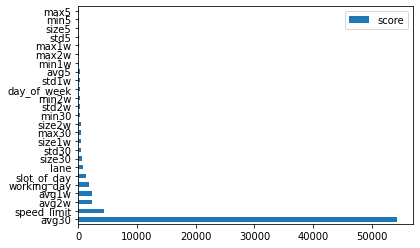

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

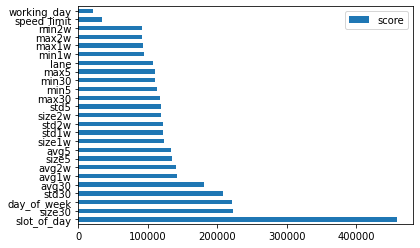

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

# Ajustando label para 06 horas adiante

In [ ]:
data_copy = data.copy()

In [ ]:
data_copy.index[-1]

2950521

In [ ]:
# before transformation
data_copy.head(10)

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,...,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,...,4.521537,32.0,25.0,58.0,47.562500,7.676822,1,67,50.799999,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,...,5.250657,26.0,33.0,59.0,50.769230,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,...,5.186414,24.0,11.0,56.0,47.250000,9.138973,1,67,50.000000,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,...,5.188073,21.0,40.0,55.0,48.571430,4.593696,1,67,48.615383,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,...,5.469811,14.0,42.0,57.0,49.500000,4.238430,1,67,48.000000,2014-08-01 00:20:00
5,1385001,4,5,3,32,32.0,58.0,50.500000,5.442885,198.0,...,5.435704,19.0,32.0,58.0,46.684212,7.616137,1,67,47.909092,2014-08-01 00:25:00
6,1385001,4,6,3,35,30.0,59.0,50.800000,6.060646,200.0,...,6.218572,14.0,40.0,57.0,50.571430,4.100771,1,67,51.416668,2014-08-01 00:30:00
7,1385001,4,7,3,26,44.0,60.0,52.692307,3.516655,192.0,...,5.138901,22.0,36.0,60.0,50.454544,5.323424,1,67,48.368420,2014-08-01 00:35:00
8,1385001,4,8,3,32,38.0,60.0,50.000000,5.618051,192.0,...,6.514599,18.0,43.0,58.0,51.611111,4.584259,1,67,49.863636,2014-08-01 00:40:00
9,1385001,4,9,3,26,27.0,57.0,48.615383,7.452810,188.0,...,5.607089,11.0,42.0,56.0,49.636364,4.656818,1,67,48.666668,2014-08-01 00:45:00


In [ ]:
hours_added = datetime.timedelta(hours = 6)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = data_copy['sensor_id'].astype(str) + data_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(data_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 6 hours information
timePlus6h = data_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+6h
sensor_timePlus6h = (data_copy['sensor_id'].astype(str) + timePlus6h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus6h
new_label = sensor_timePlus6h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
data_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
data_copy.to_csv('data-06hours.csv')

In [ ]:
test_copy = test.copy()

In [ ]:
test_copy.index

RangeIndex(start=0, stop=1715253, step=1)

In [ ]:
hours_added = datetime.timedelta(hours = 6)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = test_copy['sensor_id'].astype(str) + test_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(test_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 6 hours information
timePlus6h = test_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+6h
sensor_timePlus6h = (test_copy['sensor_id'].astype(str) + timePlus6h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus6h
new_label = sensor_timePlus6h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
test_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
test_copy.to_csv('test-06hours.csv')

## Treinando com dataset ajustado para 6 horas

### Removendo features desnecessárias

In [ ]:
## Only if kernel restarted

# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-06hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-06hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
hours_added = datetime.timedelta(hours = 6)
index = 100045
hours_ahead = data.loc[index, "timestamp5"] + hours_added

print(data.loc[index, ["sensor_id", "label", "timestamp5"]], hours_ahead)
data[((data["timestamp5"] == hours_ahead) & (data["sensor_id"] == data["sensor_id"].loc[index]))][["sensor_id", "avg5"]]

sensor_id                 1385034
label                      23.875
timestamp5    2014-08-01 23:50:00
Name: 100045, dtype: object 2014-08-02 05:50:00


,sensor_id,avg5
100114,1385034,23.875


In [ ]:
data[((data["timestamp5"] == hours_ahead))]

,Unnamed: 0,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
5152,5152,1385001,1,110,3,153,7.0,48.0,24.398693,7.500187,801.0,4.0,48.0,22.242197,7.179438,101.0,4.0,39.0,18.504950,8.276919,122.0,13.0,56.0,35.500000,12.368820,1,67,35.471910,2014-08-19 09:10:00
13823,13823,1385002,1,110,3,159,14.0,55.0,35.559750,9.254332,917.0,12.0,60.0,34.567067,9.871869,162.0,10.0,61.0,38.771606,10.744665,145.0,13.0,70.0,34.344826,11.302962,1,67,34.244755,2014-08-19 09:10:00
21202,21202,1385006,1,110,2,49,14.0,57.0,30.142857,9.657396,287.0,12.0,57.0,28.672474,7.818323,43.0,14.0,52.0,26.953489,7.511088,54.0,13.0,47.0,26.518518,8.130283,1,67,31.216217,2014-08-19 09:10:00
28562,28562,1385007,1,110,2,54,13.0,56.0,26.777779,10.407737,265.0,8.0,56.0,27.366038,9.528011,42.0,15.0,53.0,27.571428,8.883219,42.0,13.0,51.0,24.857143,8.870957,1,67,24.260870,2014-08-19 09:10:00
46725,46725,1385018,1,110,4,113,13.0,48.0,35.150444,8.960307,687.0,6.0,57.0,31.612809,9.665212,101.0,17.0,49.0,38.089108,5.565272,138.0,16.0,49.0,35.652172,6.852115,1,67,36.447760,2014-08-19 09:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626867,1626867,FS108,1,110,1,22,10.0,56.0,39.454544,13.203743,164.0,10.0,64.0,45.951220,7.823358,22.0,15.0,57.0,43.090908,10.179789,17.0,33.0,55.0,47.000000,6.173949,1,60,45.769230,2014-08-19 09:10:00
1630717,1630717,FS110,1,110,3,98,22.0,57.0,43.561226,7.063944,612.0,10.0,63.0,43.936275,7.675881,93.0,23.0,68.0,45.870968,7.233771,91.0,15.0,61.0,43.934067,7.751359,1,60,46.345680,2014-08-19 09:10:00
1635296,1635296,FS111,1,110,3,62,22.0,69.0,46.725807,8.130328,463.0,17.0,69.0,45.881210,7.458809,65.0,23.0,64.0,46.784615,8.008635,56.0,13.0,61.0,45.589287,8.620525,1,60,44.986668,2014-08-19 09:10:00
1639920,1639920,FS114,1,110,3,94,23.0,68.0,50.202130,5.762276,614.0,17.0,79.0,49.716612,6.428597,82.0,16.0,65.0,50.719513,7.724327,100.0,13.0,75.0,44.570000,9.897732,1,60,51.659092,2014-08-19 09:10:00


In [ ]:
data[((data["timestamp5"] == "2014-08-01 00:00:00") & (data["sensor_id"] == 1385001))]

,Unnamed: 0,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.5625,7.676822,1,67,40.21898,2014-08-01 00:00:00


In [ ]:
data[((data["timestamp5"] == "2014-08-01 00:06:00") & (data["sensor_id"] == 1385001))]

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5


In [ ]:
del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

In [ ]:
data.head()

,Unnamed: 0,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.56250,7.676822,1,67,40.218980,2014-08-01 00:00:00
1,1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.76923,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.25000,9.138973,1,67,35.758774,2014-08-01 00:10:00
3,3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.57143,4.593696,1,67,36.402985,2014-08-01 00:15:00
4,4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.50000,4.238430,1,67,36.008698,2014-08-01 00:20:00


### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

5.687933875921128


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.738049193975156

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

2497 4.731042


### Importância das features

In [ ]:
column_names = [*data]

In [ ]:
xgboost.get_booster().feature_names = column_names

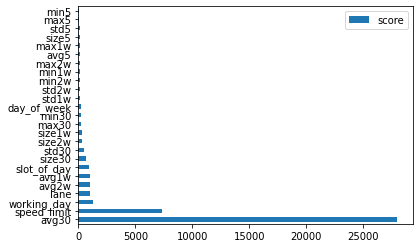

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

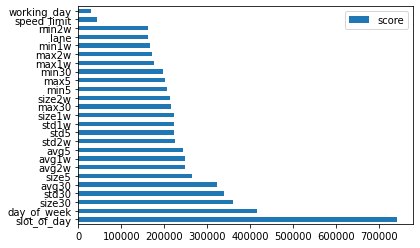

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

# Treinando com dataset de 06 horas

In [ ]:
# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-06hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-06hours.csv', parse_dates=["timestamp5"])

## Treinando sem features relacionadas a 1week e 2week

In [ ]:
data.columns

Index(['Unnamed: 0', 'sensor_id', 'day_of_week', 'slot_of_day', 'lane',
       'size5', 'min5', 'max5', 'avg5', 'std5', 'size30', 'min30', 'max30',
       'avg30', 'std30', 'size1w', 'min1w', 'max1w', 'avg1w', 'std1w',
       'size2w', 'min2w', 'max2w', 'avg2w', 'std2w', 'working_day',
       'speed_limit', 'label', 'timestamp5'],
      dtype='object')

In [ ]:
data.columns[15:25]

Index(['size1w', 'min1w', 'max1w', 'avg1w', 'std1w', 'size2w', 'min2w',
       'max2w', 'avg2w', 'std2w'],
      dtype='object')

In [ ]:
data.drop(data.iloc[:, 15:25], inplace=True, axis=1) #removing from size1w to std2w

del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

test.drop(test.iloc[:, 15:25], inplace=True, axis=1) #removing from size1w to std2w
del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

5.806425304548339


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.857775341870436

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

1381 4.859262


### Importância das features

In [ ]:
column_names = [*data]

In [ ]:
xgboost.get_booster().feature_names = column_names

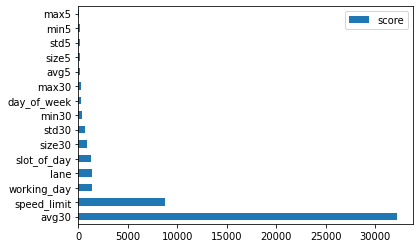

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

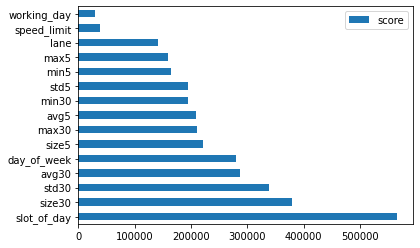

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

## Treinando somente com features de 5 minutos

In [ ]:
# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-06hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-06hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data.columns

Index(['Unnamed: 0', 'sensor_id', 'day_of_week', 'slot_of_day', 'lane',
       'size5', 'min5', 'max5', 'avg5', 'std5', 'size30', 'min30', 'max30',
       'avg30', 'std30', 'size1w', 'min1w', 'max1w', 'avg1w', 'std1w',
       'size2w', 'min2w', 'max2w', 'avg2w', 'std2w', 'working_day',
       'speed_limit', 'label', 'timestamp5'],
      dtype='object')

In [ ]:
data.columns[10:25]

Index(['size30', 'min30', 'max30', 'avg30', 'std30', 'size1w', 'min1w',
       'max1w', 'avg1w', 'std1w', 'size2w', 'min2w', 'max2w', 'avg2w',
       'std2w'],
      dtype='object')

In [ ]:
data.drop(data.iloc[:, 10:25], inplace=True, axis=1) #removing from size1w to std2w

del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

test.drop(test.iloc[:, 10:25], inplace=True, axis=1) #removing from size1w to std2w
del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

6.185177970311919


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

5.2264203873224195

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

797 5.224231


### Importância das features

In [ ]:
column_names = [*data]

In [ ]:
xgboost.get_booster().feature_names = column_names

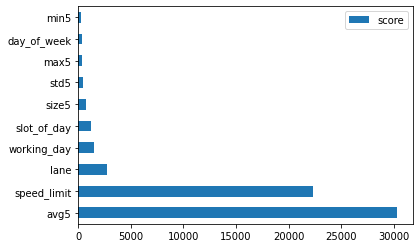

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

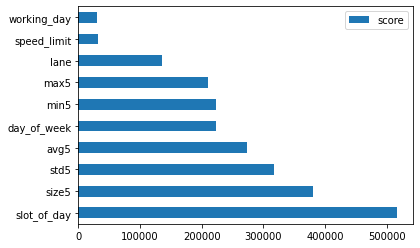

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

## Treinando somente com features de 30 minutos

In [ ]:
# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-06hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-06hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data.columns

Index(['Unnamed: 0', 'sensor_id', 'day_of_week', 'slot_of_day', 'lane',
       'size5', 'min5', 'max5', 'avg5', 'std5', 'size30', 'min30', 'max30',
       'avg30', 'std30', 'size1w', 'min1w', 'max1w', 'avg1w', 'std1w',
       'size2w', 'min2w', 'max2w', 'avg2w', 'std2w', 'working_day',
       'speed_limit', 'label', 'timestamp5'],
      dtype='object')

In [ ]:
data.drop(data.iloc[:, 5:10], inplace=True, axis=1) #removing from size1w to std2w
data.drop(data.iloc[:, 10:20], inplace=True, axis=1) #removing from size1w to std2w

del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

test.drop(test.iloc[:, 5:10], inplace=True, axis=1) #removing from size1w to std2w
test.drop(test.iloc[:, 10:20], inplace=True, axis=1) #removing from size1w to std2w
del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

5.812976549870418


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.8676348465225505

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

1020 4.878304


### Importância das features

In [ ]:
column_names = [*data]

In [ ]:
xgboost.get_booster().feature_names = column_names

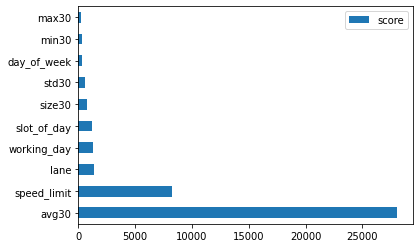

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

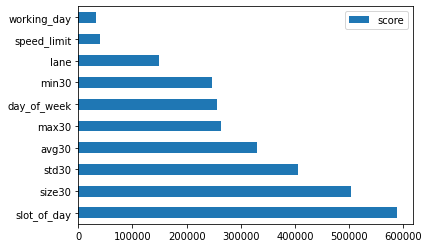

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

## Treinando somente com avg30
Conforme a importância das features mostrou, a feature `avg30` é bem mais importante que as outras. Portanto será realizado o treinamento e teste somente com esta feature.

In [ ]:
# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-06hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-06hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Divisão em treino, teste e validação

In [ ]:
data["avg30"]

0          49.678571
1          50.114943
2          50.494681
3          50.437838
4          50.576531
             ...    
2950517    21.720000
2950518    20.541667
2950519    15.555556
2950520    12.937500
2950521    19.600000
Name: avg30, Length: 2950522, dtype: float64

In [ ]:
label = data["label"].values
tr_data = data["avg30"].values

X = test["avg30"].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

In [ ]:
X_val = X_val.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Treinamento
Realizando treinamento com Regressão Linear e XGBoost.

In [ ]:
tr_data = tr_data.reshape(-1, 1)

In [ ]:
tr_data

array([[49.67857143],
       [50.11494253],
       [50.49468085],
       ...,
       [15.55555556],
       [12.9375    ],
       [19.6       ]])

In [ ]:
tr_data.shape

(2950522, 1)

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

6.070633631899165


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

6.020196054327272

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

1098 6.032063


# Ajustando label para 24 horas adiante

In [ ]:
agosto = pd.read_csv(f"{datasets}/2014_08-Traffic_Sensors_Fortaleza.csv", parse_dates=["timestamp5"])
setembro = pd.read_csv(f"{datasets}/2014_09-Traffic_Sensors_Fortaleza.csv", parse_dates=["timestamp5"])
test = pd.read_csv(f"{datasets}/2014_10-Traffic_Sensors_Fortaleza.csv", parse_dates=["timestamp5"])

data = pd.concat([agosto, setembro], ignore_index=True)
data.head()

In [ ]:
data_copy = data.copy()

In [ ]:
data_copy.index[-1]

2950521

In [ ]:
# before transformation
data_copy.head(10)

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.562500,7.676822,1,67,50.799999,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.769230,4.979247,1,67,52.692307,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.250000,9.138973,1,67,50.000000,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.571430,4.593696,1,67,48.615383,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.500000,4.238430,1,67,48.000000,2014-08-01 00:20:00
5,1385001,4,5,3,32,32.0,58.0,50.500000,5.442885,198.0,31.0,62.0,50.464646,5.625184,32.0,30.0,56.0,47.625000,5.435704,19.0,32.0,58.0,46.684212,7.616137,1,67,47.909092,2014-08-01 00:25:00
6,1385001,4,6,3,35,30.0,59.0,50.800000,6.060646,200.0,30.0,62.0,50.685000,5.617453,29.0,24.0,59.0,47.862068,6.218572,14.0,40.0,57.0,50.571430,4.100771,1,67,51.416668,2014-08-01 00:30:00
7,1385001,4,7,3,26,44.0,60.0,52.692307,3.516655,192.0,30.0,60.0,50.770833,5.421752,17.0,40.0,59.0,50.058823,5.138901,22.0,36.0,60.0,50.454544,5.323424,1,67,48.368420,2014-08-01 00:35:00
8,1385001,4,8,3,32,38.0,60.0,50.000000,5.618051,192.0,30.0,60.0,50.505208,5.512294,20.0,34.0,58.0,48.599998,6.514599,18.0,43.0,58.0,51.611111,4.584259,1,67,49.863636,2014-08-01 00:40:00
9,1385001,4,9,3,26,27.0,57.0,48.615383,7.452810,188.0,27.0,60.0,50.441489,5.839318,17.0,34.0,54.0,47.823528,5.607089,11.0,42.0,56.0,49.636364,4.656818,1,67,48.666668,2014-08-01 00:45:00


In [ ]:
hours_added = datetime.timedelta(hours = 24)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = data_copy['sensor_id'].astype(str) + data_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(data_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 24 hours information
timePlus24h = data_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+24h
sensor_timePlus24h = (data_copy['sensor_id'].astype(str) + timePlus24h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus24h
new_label = sensor_timePlus24h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
data_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
data_copy.head(10)

,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1385001,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,55.0,40.0,58.0,49.654545,4.521537,32.0,25.0,58.0,47.562500,7.676822,1,67,49.409092,2014-08-01 00:00:00
1,1385001,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,51.0,37.0,60.0,49.862743,5.250657,26.0,33.0,59.0,50.769230,4.979247,1,67,48.846153,2014-08-01 00:05:00
2,1385001,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,30.0,37.0,56.0,48.966667,5.186414,24.0,11.0,56.0,47.250000,9.138973,1,67,48.896553,2014-08-01 00:10:00
3,1385001,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,21.0,37.0,58.0,49.190475,5.188073,21.0,40.0,55.0,48.571430,4.593696,1,67,47.820515,2014-08-01 00:15:00
4,1385001,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,31.0,34.0,58.0,48.870968,5.469811,14.0,42.0,57.0,49.500000,4.238430,1,67,50.224490,2014-08-01 00:20:00
5,1385001,4,5,3,32,32.0,58.0,50.500000,5.442885,198.0,31.0,62.0,50.464646,5.625184,32.0,30.0,56.0,47.625000,5.435704,19.0,32.0,58.0,46.684212,7.616137,1,67,47.968750,2014-08-01 00:25:00
6,1385001,4,6,3,35,30.0,59.0,50.800000,6.060646,200.0,30.0,62.0,50.685000,5.617453,29.0,24.0,59.0,47.862068,6.218572,14.0,40.0,57.0,50.571430,4.100771,1,67,51.560974,2014-08-01 00:30:00
7,1385001,4,7,3,26,44.0,60.0,52.692307,3.516655,192.0,30.0,60.0,50.770833,5.421752,17.0,40.0,59.0,50.058823,5.138901,22.0,36.0,60.0,50.454544,5.323424,1,67,50.125000,2014-08-01 00:35:00
8,1385001,4,8,3,32,38.0,60.0,50.000000,5.618051,192.0,30.0,60.0,50.505208,5.512294,20.0,34.0,58.0,48.599998,6.514599,18.0,43.0,58.0,51.611111,4.584259,1,67,49.571430,2014-08-01 00:40:00
9,1385001,4,9,3,26,27.0,57.0,48.615383,7.452810,188.0,27.0,60.0,50.441489,5.839318,17.0,34.0,54.0,47.823528,5.607089,11.0,42.0,56.0,49.636364,4.656818,1,67,48.515152,2014-08-01 00:45:00


In [ ]:
data_copy.to_csv('data-24hours.csv')
!cp data-24hours.csv '{datasets}'

In [ ]:
test_copy = test.copy()

In [ ]:
test_copy.index

RangeIndex(start=0, stop=1715253, step=1)

In [ ]:
hours_added = datetime.timedelta(hours = 24)

# Create a data series that combines the information about sensor_id & timestamp5
sen_time = test_copy['sensor_id'].astype(str) + test_copy['timestamp5'].astype(str)

# Create a dictionary of the corresponding { sensor_id + timestamp5 : avg5 } values
dictionary = pd.Series(test_copy['avg5'].values, sen_time).to_dict()

# Create a data series combining the timestamp5 + 24 hours information
timePlus24h = test_copy['timestamp5'] + hours_added

# Create a mapping column that combines the sensor_id & timestamp5+24h
sensor_timePlus24h = (test_copy['sensor_id'].astype(str) + timePlus24h.astype(str))

# Create a new_label series by mapping the dictionary onto sensor_timePlus24h
new_label = sensor_timePlus24h.map(dictionary)

# Extract indices where this series has non-NaN values
where = new_label.notnull()

# Replace the values in the 'label' column with only non-NaN new_label values
test_copy.loc[where, 'label'] = new_label.loc[where]

In [ ]:
test_copy.to_csv('test-24hours.csv')
!cp test-24hours.csv '{datasets}'

## Treinando com dataset ajustado para 24 horas

### Removendo features desnecessárias

In [ ]:
## Only if kernel restarted

# Agosto + Setembro de 2014
data = pd.read_csv(f'{datasets}/data-24hours.csv', parse_dates=["timestamp5"])

# Outubro como teste
test = pd.read_csv(f'{datasets}/test-24hours.csv', parse_dates=["timestamp5"])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
hours_added = datetime.timedelta(hours = 24)
index = 1
hours_ahead = data.loc[index, "timestamp5"] + hours_added

print(data.loc[index, ["sensor_id", "label", "timestamp5"]], hours_ahead)
data[((data["timestamp5"] == hours_ahead) & (data["sensor_id"] == data["sensor_id"].loc[index]))][["sensor_id", "avg5", "timestamp5"]]

sensor_id                 1385001
label                     48.8462
timestamp5    2014-08-01 00:05:00
Name: 1, dtype: object 2014-08-02 00:05:00


,sensor_id,avg5,timestamp5
287,1385001,48.846153,2014-08-02 00:05:00


In [ ]:
data.drop(data.iloc[:, 15:25], inplace=True, axis=1) #removing from size1w to std2w

del data['sensor_id']
del data['timestamp5']
del data['Unnamed: 0']

test.drop(test.iloc[:, 15:25], inplace=True, axis=1) #removing from size1w to std2w
del test['sensor_id']
del test['timestamp5']
del test['Unnamed: 0']

In [ ]:
data.head()

,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,working_day,speed_limit,label
0,4,0,3,33,32.0,59.0,49.484848,6.035859,168.0,25.0,61.0,49.678571,5.961505,1,67,49.409092
1,4,1,3,34,35.0,62.0,51.735294,5.569396,174.0,25.0,62.0,50.114943,6.018984,1,67,48.846153
2,4,2,3,32,37.0,60.0,51.593750,5.011608,188.0,25.0,62.0,50.494681,5.920122,1,67,48.896553
3,4,3,3,30,31.0,57.0,49.266666,5.519260,185.0,29.0,62.0,50.437838,5.835370,1,67,47.820515
4,4,4,3,37,31.0,60.0,50.135136,5.619282,196.0,31.0,62.0,50.576531,5.621502,1,67,50.224490


### Divisão em treino, teste e validação

In [ ]:
label = data["label"].values
tr_data = data.iloc[:,:-1].values

X = test.iloc[:,:-1].values
y = test["label"].values

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

### Treinamento

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
lr = LinearRegression()

lr.fit(tr_data, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lr.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(rmse)

4.669718007011461


In [ ]:
xgboost = xgb.XGBRegressor(n_estimators=3000, tree_method='gpu_hist', objective ='reg:squarederror', learning_rate=0.01,
                            max_depth=12, random_state=seed)

In [ ]:
xgboost.fit(tr_data, label, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
pred_xgb = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))

rmse_xgb

4.432129857429031

In [ ]:
print(xgboost.best_ntree_limit, xgboost.best_score)

650 4.419127


### Importância das features

In [ ]:
column_names = [*data]

In [ ]:
xgboost.get_booster().feature_names = column_names

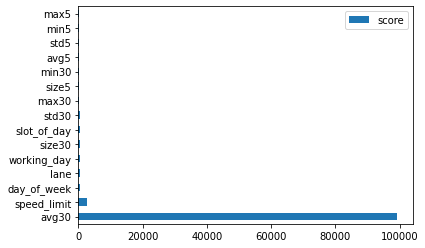

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

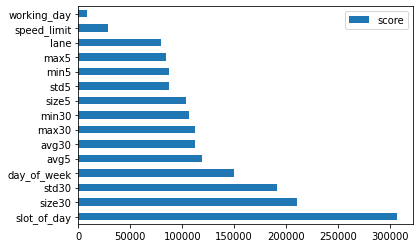

In [ ]:
feature_important = xgboost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt.plot(kind='barh')

# Avaliação com AutoML

## Instalando e iniciando H2O

In [ ]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [ ]:
#!pip install h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 129.4MB 61kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.2-py2.py3-none-any.whl size=129446949 sha256=bc7faf13cbb98ddb10f19f0096c4c5db202f42aff2b60cc6e2c9a1908f471a3a
  Stored in directory: /root/.cache/pip/wheels/c6/be/83/a33a3c1c97fce1d136222bf4ed6d79da405ef6103f5b434c1e
Successfully built h2o


In [ ]:
#JVM is already installed
import h2o
h2o.no_progress()

h2o.init(nthreads=-1, max_mem_size="18G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmps5638fem
  JVM stdout: /tmp/tmps5638fem/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmps5638fem/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_v8ryl0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,18 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
#h2o.cluster().shutdown()

## Configurações globais

In [ ]:
#import h2o_utils
from h2o.automl import H2OAutoML

## Separando dados em treino, teste e validação

In [ ]:
data = h2o.import_file(f"{datasets}/data-06hours.csv")
test = h2o.import_file(f"{datasets}/test-06hours.csv")

### Juntando datasets de agosto e setembro

In [ ]:
# combining two h2o frames
#data = agosto.rbind(setembro)

In [ ]:
data.head()

C1,sensor_id,day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,size1w,min1w,max1w,avg1w,std1w,size2w,min2w,max2w,avg2w,std2w,working_day,speed_limit,label,timestamp5
0,1.385e+06,4,0,3,33,32,59,49.4848,6.03586,168,25,61,49.6786,5.9615,55,40,58,49.6545,4.52154,32,25,58,47.5625,7.67682,1,67,40.219,2014-08-01 00:00:00
1,1.385e+06,4,1,3,34,35,62,51.7353,5.5694,174,25,62,50.1149,6.01898,51,37,60,49.8627,5.25066,26,33,59,50.7692,4.97925,1,67,52.6923,2014-08-01 00:05:00
2,1.385e+06,4,2,3,32,37,60,51.5938,5.01161,188,25,62,50.4947,5.92012,30,37,56,48.9667,5.18641,24,11,56,47.25,9.13897,1,67,35.7588,2014-08-01 00:10:00
3,1.385e+06,4,3,3,30,31,57,49.2667,5.51926,185,29,62,50.4378,5.83537,21,37,58,49.1905,5.18807,21,40,55,48.5714,4.5937,1,67,36.403,2014-08-01 00:15:00
4,1.385e+06,4,4,3,37,31,60,50.1351,5.61928,196,31,62,50.5765,5.6215,31,34,58,48.871,5.46981,14,42,57,49.5,4.23843,1,67,36.0087,2014-08-01 00:20:00
5,1.385e+06,4,5,3,32,32,58,50.5,5.44289,198,31,62,50.4646,5.62518,32,30,56,47.625,5.4357,19,32,58,46.6842,7.61614,1,67,34.5928,2014-08-01 00:25:00
6,1.385e+06,4,6,3,35,30,59,50.8,6.06065,200,30,62,50.685,5.61745,29,24,59,47.8621,6.21857,14,40,57,50.5714,4.10077,1,67,34.352,2014-08-01 00:30:00
7,1.385e+06,4,7,3,26,44,60,52.6923,3.51666,192,30,60,50.7708,5.42175,17,40,59,50.0588,5.1389,22,36,60,50.4545,5.32342,1,67,34.9718,2014-08-01 00:35:00
8,1.385e+06,4,8,3,32,38,60,50,5.61805,192,30,60,50.5052,5.51229,20,34,58,48.6,6.5146,18,43,58,51.6111,4.58426,1,67,35.7839,2014-08-01 00:40:00
9,1.385e+06,4,9,3,26,27,57,48.6154,7.45281,188,27,60,50.4415,5.83932,17,34,54,47.8235,5.60709,11,42,56,49.6364,4.65682,1,67,37.4277,2014-08-01 00:45:00


In [ ]:
data.columns[15:25]

['size1w',
 'min1w',
 'max1w',
 'avg1w',
 'std1w',
 'size2w',
 'min2w',
 'max2w',
 'avg2w',
 'std2w']

In [ ]:
data = data.drop(data.columns[15:25])
data = data.drop("sensor_id")
data = data.drop("timestamp5")
data = data.drop('C1')

test = test.drop(test.columns[15:25])
test = test.drop("sensor_id")
test = test.drop("timestamp5")
test = test.drop('C1')

In [ ]:
test.head()

day_of_week,slot_of_day,lane,size5,min5,max5,avg5,std5,size30,min30,max30,avg30,std30,working_day,speed_limit,label
2,0,3,35,31,58,51.3143,4.86839,155,30,60,49.7935,6.13998,1,67,35.3421
2,1,3,38,23,60,48.3684,8.43371,176,23,60,49.7898,6.46196,1,67,33.9073
2,2,3,23,26,56,49.3913,6.69029,178,23,60,49.7528,6.45778,1,67,30.0479
2,3,2,20,34,60,49.9,5.38424,176,23,60,49.608,6.30293,1,67,36.0632
2,4,2,20,42,59,51.2,4.72864,167,23,60,49.8024,6.36818,1,67,41.5906
2,5,2,21,35,59,47.5238,6.87036,157,23,60,49.6178,6.62223,1,67,31.1977
2,6,3,22,40,60,50.4545,5.24601,144,23,60,49.3333,6.75154,1,67,34.7475
2,7,2,16,33,57,47.9375,7.43698,122,26,60,49.4508,6.23331,1,67,36.2976
2,8,2,15,38,57,50.9333,5.335,114,33,60,49.6579,6.0449,1,67,34.5392
2,9,2,9,41,55,47.4444,4.19288,103,33,60,49.4175,6.05881,1,67,35.02


In [ ]:
X = data.columns
y = "label"

X.remove(y) #removing label
X

['day_of_week',
 'slot_of_day',
 'lane',
 'size5',
 'min5',
 'max5',
 'avg5',
 'std5',
 'size30',
 'min30',
 'max30',
 'avg30',
 'std30',
 'working_day',
 'speed_limit']

## Treinamento e predição

### Treinamento

Sem distinção de algoritmos

In [ ]:
hour = int(6 * 60 * 60)

aml = H2OAutoML(max_models=20, seed=seed, max_runtime_secs=hour, stopping_metric="RMSE", sort_metric="RMSE")

In [ ]:
start = time()
aml.train(x=X, y=y, training_frame=data)

print(f"Elapsed {time() - start}")

AutoML progress: |Failed polling AutoML progress log: Job<$03017f00000132d4ffffffff$_a4e96899f0677921cb472676c8840b9> was cancelled by the user.
█
23:36:54.12: New models will be added to existing leaderboard AutoML_20200916_233514170@@label (leaderboard frame=null) with already 0 models.

Failed polling AutoML progress log: Job<$03017f00000132d4ffffffff$_9fb0017318a8c7ec4ec460b5e3d94a13> was cancelled by the user.
█ (cancelled)
Failed polling AutoML progress log: Server error java.lang.IllegalArgumentException:
  Error: class water.fvec.Frame AutoML_20200916_233514170_eventlog is already in use.  Unable to use it now.  Consider using a different destination name.
  Request: POST /3/Parse
    data: {'destination_frame': 'AutoML_20200916_233514170_eventlog', 'parse_type': 'CSV', 'separator': '44', 'single_quotes': 'False', 'check_header': '1', 'number_columns': '7', 'chunk_size': '4194304', 'delete_on_done': 'True', 'blocking': 'False', 'column_types': '["string","string","string","stri

H2OJobCancelled: ignored

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

### Checando performance dos modelos
Analisando todo o leaderboard

In [ ]:
model_ids = lb.as_data_frame(lb)

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  preds = model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

In [ ]:
# Checando performance
perf_data = []

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  perf = model.model_performance(test)
  perf_data.append([item, perf.rmse(), perf.mse(), perf.mae()])

In [ ]:
perf_data[0]

['StackedEnsemble_AllModels_AutoML_20200908_131459',
 4.8524669829066305,
 23.546435820198976,
 3.3171831876072346]

In [ ]:
# Salvando dados em um dataframe

results = pd.DataFrame(data=perf_data, columns=['Model', 'RMSE', 'MSE', 'MAE'])

In [ ]:
results

,Model,RMSE,MSE,MAE
0,StackedEnsemble_AllModels_AutoML_20200908_131459,4.852467,23.546436,3.317183
1,StackedEnsemble_BestOfFamily_AutoML_20200908_1...,4.870399,23.720783,3.337022
2,XGBoost_grid__1_AutoML_20200908_131459_model_2,4.899123,24.001402,3.368613
3,GBM_grid__1_AutoML_20200908_131459_model_1,4.906542,24.074150,3.380688
4,DRF_1_AutoML_20200908_131459,4.925022,24.255837,3.380076
5,XRT_1_AutoML_20200908_131459,4.940212,24.405699,3.396485
6,XGBoost_2_AutoML_20200908_131459,5.026856,25.269278,3.474562
7,XGBoost_1_AutoML_20200908_131459,4.944592,24.448994,3.406764
8,GBM_5_AutoML_20200908_131459,4.924606,24.251745,3.461603
9,XGBoost_grid__1_AutoML_20200908_131459_model_1,5.170827,26.737453,3.561110


## Listando hiperparâmetros não padrões do modelo

In [ ]:
def h2o_not_default_params_df(model):
    params = model.params
    result = []
    ignore_params = ['model_id', 'training_frame', 'validation_frame', 'response_column', 'ignored_columns']
    for k in params:
        if k not in ignore_params and params[k]['default'] != params[k]['actual']:
            result.append({ 'param': k, 'default': params[k]['default'], 
                            'actual': params[k]['actual']})
    df_ = pd.DataFrame(result)
    cols = ['param', 'default', 'actual']
    return df_[ cols ]

In [ ]:
for item in results['Model']:
  model = h2o.get_model(item)
  print(f'{item}, h2o_not_default_params_df(model)')

## Salvando modelos

Salvando modelos treinados no Drive (para evitar retreinamento)

In [ ]:
for item in results.Model:
  model_to_save = h2o.get_model(item)

  # salvando o modelo
  h2o.save_model(model=model_to_save, path=f"{path}/h2o", force=True)

## Treinando para cada algoritmo

Vamos realizar o processo de treinamento para cada algoritmo, separadamente.

### DRF

In [ ]:
hour = int(10 * 60 * 60)

aml = H2OAutoML(max_models=20, seed=seed, max_runtime_secs=hour, stopping_metric="RMSE",
                sort_metric="RMSE", include_algos=["DRF"])

In [ ]:
start = time()
aml.train(x=X, y=y, training_frame=data)

print(f"Elapsed {time() - start}")

AutoML progress: |████████████████████████████████████████████████████████| 100%| 100%
Elapsed 5020.500298976898


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
DRF_1_AutoML_20200911_022349,4.40257,19.3827,19.3827,3.05121,0.148377
XRT_1_AutoML_20200911_022349,4.43498,19.6691,19.6691,3.07676,0.149301


#### Checando performance dos modelos
Analisando todo o leaderboard

In [ ]:
model_ids = lb.as_data_frame(lb)

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  preds = model.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Checando performance
perf_data = []

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  perf = model.model_performance(test)
  perf_data.append([item, perf.rmse(), perf.mse(), perf.mae()])

In [ ]:
perf_data[0]

['DRF_1_AutoML_20200911_022349',
 4.870054949465248,
 23.717435210810965,
 3.338464490457102]

In [ ]:
# Salvando dados em um dataframe

results = pd.DataFrame(data=perf_data, columns=['Model', 'RMSE', 'MSE', 'MAE'])

In [ ]:
results

,Model,RMSE,MSE,MAE
0,DRF_1_AutoML_20200911_022349,4.870055,23.717435,3.338464
1,XRT_1_AutoML_20200911_022349,4.884549,23.858817,3.352636


#### Listando hiperparâmetros não padrões do modelo

In [ ]:
def h2o_not_default_params_df(model):
    params = model.params
    result = []
    ignore_params = ['model_id', 'training_frame', 'validation_frame', 'response_column', 'ignored_columns']
    for k in params:
        if k not in ignore_params and params[k]['default'] != params[k]['actual']:
            result.append({ 'param': k, 'default': params[k]['default'], 
                            'actual': params[k]['actual']})
    df_ = pd.DataFrame(result)
    cols = ['param', 'default', 'actual']
    return df_[ cols ]

In [ ]:
for item in results['Model']:
  model = h2o.get_model(item)
  df = h2o_not_default_params_df(model)
  df.to_csv(f'{csv_folder}/{item}_params.csv', index=False)

In [ ]:
df

,param,default,actual
0,nfolds,0,5
1,keep_cross_validation_models,True,False
2,keep_cross_validation_predictions,False,True
3,score_tree_interval,0,5
4,fold_assignment,AUTO,Modulo
5,stopping_metric,AUTO,RMSE
6,seed,-1,43
7,histogram_type,AUTO,Random
8,categorical_encoding,AUTO,Enum
9,distribution,AUTO,gaussian


#### Salvando modelos

Salvando modelos treinados no Drive (para evitar retreinamento)

In [ ]:
for item in results.Model:
  model_to_save = h2o.get_model(item)

  # salvando o modelo
  h2o.save_model(model=model_to_save, path=f"{path}/h2o/DRF", force=True)

### GLM

In [ ]:
hour = int(10 * 60 * 60)

aml = H2OAutoML(max_models=20, seed=seed, max_runtime_secs=hour, stopping_metric="RMSE",
                sort_metric="RMSE", include_algos=["GLM"])

In [ ]:
start = time()
aml.train(x=X, y=y, training_frame=data)

print(f"Elapsed {time() - start}")

AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed 130.30837440490723


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
GLM_1_AutoML_20200911_161050,5.52042,30.475,30.475,3.96401,0.182124


#### Checando performance dos modelos
Analisando todo o leaderboard

In [ ]:
model_ids = lb.as_data_frame(lb)

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  preds = model.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Checando performance
perf_data = []

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  perf = model.model_performance(test)
  perf_data.append([item, perf.rmse(), perf.mse(), perf.mae()])

In [ ]:
perf_data[0]

['GLM_1_AutoML_20200911_161050',
 5.8105883139017145,
 33.762936553651166,
 4.13908801242176]

In [ ]:
# Salvando dados em um dataframe

results = pd.DataFrame(data=perf_data, columns=['Model', 'RMSE', 'MSE', 'MAE'])

In [ ]:
results

,Model,RMSE,MSE,MAE
0,GLM_1_AutoML_20200911_161050,5.810588,33.762937,4.139088


#### Listando hiperparâmetros não padrões do modelo

In [ ]:
def h2o_not_default_params_df(model):
    params = model.params
    result = []
    ignore_params = ['model_id', 'training_frame', 'validation_frame', 'response_column', 'ignored_columns']
    for k in params:
        if k not in ignore_params and params[k]['default'] != params[k]['actual']:
            result.append({ 'param': k, 'default': params[k]['default'], 
                            'actual': params[k]['actual']})
    df_ = pd.DataFrame(result)
    cols = ['param', 'default', 'actual']
    return df_[ cols ]

In [ ]:
for item in results['Model']:
  model = h2o.get_model(item)
  df = h2o_not_default_params_df(model)
  df.to_csv(f'{csv_folder}/{item}_params.csv', index=False)

In [ ]:
df

,param,default,actual
0,nfolds,0,5
1,seed,-1,42
2,keep_cross_validation_models,True,False
3,keep_cross_validation_predictions,False,True
4,fold_assignment,AUTO,Modulo
5,family,AUTO,gaussian
6,solver,AUTO,COORDINATE_DESCENT
7,alpha,None,"[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]"
8,lambda,None,"[783.6234027248552, 486.6434091548491, 302.213..."
9,lambda_search,False,True


#### Salvando modelos

Salvando modelos treinados no Drive (para evitar retreinamento)

In [ ]:
for item in results.Model:
  model_to_save = h2o.get_model(item)

  # salvando o modelo
  h2o.save_model(model=model_to_save, path=f"{path}/h2o/GLM", force=True)

### XGBoost

In [ ]:
hour = int(6 * 60 * 60)

aml = H2OAutoML(max_models=20, seed=seed, max_runtime_secs=hour, stopping_metric="RMSE",
                sort_metric="RMSE", include_algos=["XGBoost"])

In [ ]:
start = time()
aml.train(x=X, y=y, training_frame=data)

print(f"Elapsed {time() - start}")

AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed 21602.20094847679


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
XGBoost_grid__1_AutoML_20200919_021853_model_2,4.48677,20.1311,20.1311,3.12179,nan
XGBoost_1_AutoML_20200919_021853,4.53959,20.6079,20.6079,3.16483,0.152021
XGBoost_2_AutoML_20200919_021853,4.54193,20.6291,20.6291,3.16804,0.151847
XGBoost_grid__1_AutoML_20200919_021853_model_1,4.66618,21.7733,21.7733,3.26422,0.15568
XGBoost_3_AutoML_20200919_021853,4.7056,22.1426,22.1426,3.29677,0.156863


#### Checando performance dos modelos
Analisando todo o leaderboard

In [ ]:
model_ids = lb.as_data_frame(lb)

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  preds = model.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [ ]:
# Checando performance
perf_data = []

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  perf = model.model_performance(test)
  perf_data.append([item, perf.rmse(), perf.mse(), perf.mae()])

In [ ]:
perf_data[0]

['XGBoost_grid__1_AutoML_20200919_021853_model_2',
 4.921751084558736,
 24.223633738355087,
 3.383296222025877]

In [ ]:
# Salvando dados em um dataframe

results = pd.DataFrame(data=perf_data, columns=['Model', 'RMSE', 'MSE', 'MAE'])

In [ ]:
results

,Model,RMSE,MSE,MAE
0,XGBoost_grid__1_AutoML_20200919_021853_model_2,4.921751,24.223634,3.383296
1,XGBoost_1_AutoML_20200919_021853,4.943122,24.434456,3.404425
2,XGBoost_2_AutoML_20200919_021853,5.062022,25.624065,3.486643
3,XGBoost_grid__1_AutoML_20200919_021853_model_1,5.005987,25.059904,3.464607
4,XGBoost_3_AutoML_20200919_021853,5.034758,25.348792,3.495384


#### Listando hiperparâmetros não padrões do modelo

In [ ]:
def h2o_not_default_params_df(model):
    params = model.params
    result = []
    ignore_params = ['model_id', 'training_frame', 'validation_frame', 'response_column', 'ignored_columns']
    for k in params:
        if k not in ignore_params and params[k]['default'] != params[k]['actual']:
            result.append({ 'param': k, 'default': params[k]['default'], 
                            'actual': params[k]['actual']})
    df_ = pd.DataFrame(result)
    cols = ['param', 'default', 'actual']
    return df_[ cols ]

In [ ]:
for item in results['Model']:
  model = h2o.get_model(item)
  df = h2o_not_default_params_df(model)
  df.to_csv(f'{csv_folder}/{item}_params.csv', index=False)

In [ ]:
df

,param,default,actual
0,nfolds,0,5
1,keep_cross_validation_models,True,False
2,keep_cross_validation_predictions,False,True
3,fold_assignment,AUTO,Modulo
4,stopping_metric,AUTO,RMSE
5,seed,-1,44
6,distribution,AUTO,gaussian
7,categorical_encoding,AUTO,OneHotInternal
8,ntrees,50,171
9,max_depth,6,5


#### Salvando modelos

Salvando modelos treinados no Drive (para evitar retreinamento)

In [ ]:
for item in results.Model:
  model_to_save = h2o.get_model(item)

  # salvando o modelo
  h2o.save_model(model=model_to_save, path=f"{path}/h2o/XGBoost", force=True)

### DeepLearning

In [ ]:
hour = int(6 * 60 * 60)

aml = H2OAutoML(max_models=20, seed=seed, max_runtime_secs=hour, stopping_metric="RMSE",
                sort_metric="RMSE", include_algos=["DeepLearning"])

In [ ]:
start = time()
aml.train(x=X, y=y, training_frame=data)

print(f"Elapsed {time() - start}")

Failed polling AutoML progress log: Job<$03017f00000132d4ffffffff$_8f4b141caccea5724dbe1e7f9caa461b> was cancelled by the user.


H2OJobCancelled: ignored

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
DeepLearning_1_AutoML_20200921_185307,4.98095,24.8099,24.8099,3.48752,0.166522
DeepLearning_grid__1_AutoML_20200921_185307_model_2,4.99736,24.9737,24.9737,3.51821,0.166444
DeepLearning_grid__2_AutoML_20200921_185307_model_1,5.00078,25.0078,25.0078,3.6395,0.166462
DeepLearning_grid__1_AutoML_20200921_185307_model_1,5.19066,26.9429,26.9429,3.68594,0.171759
DeepLearning_grid__1_AutoML_20200921_185307_model_3,5.32819,28.3897,28.3897,3.85158,nan
DeepLearning_grid__3_AutoML_20200921_185307_model_1,5.75982,33.1755,33.1755,4.41258,0.185109


#### Checando performance dos modelos
Analisando todo o leaderboard

In [ ]:
model_ids = lb.as_data_frame(lb)

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  preds = model.predict(test)

In [ ]:
# Checando performance
perf_data = []

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  perf = model.model_performance(test)
  perf_data.append([item, perf.rmse(), perf.mse(), perf.mae()])

In [ ]:
perf_data[0]

['DeepLearning_1_AutoML_20200921_185307',
 5.2530302810809495,
 27.594327133953403,
 3.625627145757134]

In [ ]:
# Salvando dados em um dataframe

results = pd.DataFrame(data=perf_data, columns=['Model', 'RMSE', 'MSE', 'MAE'])

In [ ]:
results

,Model,RMSE,MSE,MAE
0,DeepLearning_1_AutoML_20200921_185307,5.253030,27.594327,3.625627
1,DeepLearning_grid__1_AutoML_20200921_185307_mo...,5.264251,27.712341,3.689570
2,DeepLearning_grid__2_AutoML_20200921_185307_mo...,5.249134,27.553411,3.704045
3,DeepLearning_grid__1_AutoML_20200921_185307_mo...,5.567333,30.995199,3.926157
4,DeepLearning_grid__1_AutoML_20200921_185307_mo...,5.572541,31.053208,3.988347
5,DeepLearning_grid__3_AutoML_20200921_185307_mo...,7.708919,59.427435,6.457377


#### Listando hiperparâmetros não padrões do modelo

In [ ]:
def h2o_not_default_params_df(model):
    params = model.params
    result = []
    ignore_params = ['model_id', 'training_frame', 'validation_frame', 'response_column', 'ignored_columns']
    for k in params:
        if k not in ignore_params and params[k]['default'] != params[k]['actual']:
            result.append({ 'param': k, 'default': params[k]['default'], 
                            'actual': params[k]['actual']})
    df_ = pd.DataFrame(result)
    cols = ['param', 'default', 'actual']
    return df_[ cols ]

In [ ]:
for item in results['Model']:
  model = h2o.get_model(item)
  df = h2o_not_default_params_df(model)
  df.to_csv(f'{csv_folder}/{item}_params.csv', index=False)

In [ ]:
df

,param,default,actual
0,nfolds,0,5
1,keep_cross_validation_models,True,False
2,keep_cross_validation_predictions,False,True
3,fold_assignment,AUTO,Modulo
4,overwrite_with_best_model,True,False
5,activation,Rectifier,RectifierWithDropout
6,hidden,"[200, 200]","[50, 50, 50]"
7,epochs,10,4.05364
8,seed,-1,57
9,input_dropout_ratio,0,0.05


#### Salvando modelos

Salvando modelos treinados no Drive (para evitar retreinamento)

In [ ]:
for item in results.Model:
  model_to_save = h2o.get_model(item)

  # salvando o modelo
  h2o.save_model(model=model_to_save, path=f"{path}/h2o/DeepLearning", force=True)

### StackedEnsemble

In [ ]:
hour = int(1000*1000*1000*1000)

aml = H2OAutoML(seed=seed, stopping_metric="RMSE",
                sort_metric="RMSE", include_algos=["StackedEnsemble"])

In [ ]:
start = time()
aml.train(x=X, y=y, training_frame=data)

print(f"Elapsed {time() - start}")


03:31:20.316: Empty leaderboard.
AutoML was not able to build any model within a max runtime constraint of 3600 seconds, you may want to increase this value before retrying.

Elapsed 0.9991586208343506


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

This H2OFrame is empty.


#### Checando performance dos modelos
Analisando todo o leaderboard

In [ ]:
model_ids = lb.as_data_frame(lb)

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  preds = model.predict(test)

TypeError: ignored

In [ ]:
# Checando performance
perf_data = []

for item in model_ids['model_id']:
  model = h2o.get_model(item)
  perf = model.model_performance(test)
  perf_data.append([item, perf.rmse(), perf.mse(), perf.mae()])

In [ ]:
perf_data[0]

In [ ]:
# Salvando dados em um dataframe

results = pd.DataFrame(data=perf_data, columns=['Model', 'RMSE', 'MSE', 'MAE'])

In [ ]:
results

#### Listando hiperparâmetros não padrões do modelo

In [ ]:
def h2o_not_default_params_df(model):
    params = model.params
    result = []
    ignore_params = ['model_id', 'training_frame', 'validation_frame', 'response_column', 'ignored_columns']
    for k in params:
        if k not in ignore_params and params[k]['default'] != params[k]['actual']:
            result.append({ 'param': k, 'default': params[k]['default'], 
                            'actual': params[k]['actual']})
    df_ = pd.DataFrame(result)
    cols = ['param', 'default', 'actual']
    return df_[ cols ]

In [ ]:
for item in results['Model']:
  model = h2o.get_model(item)
  df = h2o_not_default_params_df(model)
  df.to_csv(f'{csv_folder}/{item}_params.csv', index=False)

In [ ]:
df

#### Salvando modelos

Salvando modelos treinados no Drive (para evitar retreinamento)

In [ ]:
for item in results.Model:
  model_to_save = h2o.get_model(item)

  # salvando o modelo
  h2o.save_model(model=model_to_save, path=f"{path}/h2o/StackedEnsemble", force=True)